In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array

2024-11-22 13:23:23.932658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732256604.132348   12157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732256604.189563   12157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 13:23:24.595467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Path ke direktori dataset
train_dir = '../datasets/train_looking_left_set'
validation_dir = '../datasets/test_looking_left_set'

In [14]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1202 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [15]:
# Load MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [16]:
checkpoint_path = "../model_download/looking_left/pertama/model_looking_left.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.8225 - Recall: 0.8155 - accuracy: 0.8321 - loss: 0.3473
Epoch 1: val_accuracy improved from -inf to 0.64931, saving model to ../model_download/looking_left/pertama/model_looking_left.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - Precision: 0.8241 - Recall: 0.8174 - accuracy: 0.8335 - loss: 0.3452 - val_Precision: 0.9565 - val_Recall: 0.3077 - val_accuracy: 0.6493 - val_loss: 1.5082
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - Precision: 1.0000 - Recall: 0.8667 - accuracy: 0.9375 - loss: 0.2821

2024-11-22 14:21:02.477526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4711722432141475843
/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-22 14:21:05.779555: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4711722432141475843
2024-11-22 14:21:05.779667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17882001814243245653



Epoch 2: val_accuracy did not improve from 0.64931
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - Precision: 1.0000 - Recall: 0.8667 - accuracy: 0.9375 - loss: 0.2821 - val_Precision: 0.7500 - val_Recall: 0.3750 - val_accuracy: 0.5714 - val_loss: 0.7060
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9305 - Recall: 0.9827 - accuracy: 0.9537 - loss: 0.1283
Epoch 3: val_accuracy improved from 0.64931 to 0.72569, saving model to ../model_download/looking_left/pertama/model_looking_left.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - Precision: 0.9308 - Recall: 0.9825 - accuracy: 0.9538 - loss: 0.1280 - val_Precision: 0.9583 - val_Recall: 0.4759 - val_accuracy: 0.7257 - val_loss: 1.1476
Epoch 4/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Precision: 1.0000 - Recall: 0.8571 - accuracy: 0.9375 - loss: 0.1202
Epoch 4: val_accuracy did not improve from 0.72569
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 1.0000 - Recall: 0.8571 - accuracy: 0.9375 - loss: 0.1202 - val_Precisi

In [18]:
# Unfreeze beberapa layers dari base model untuk fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile model dengan learning rate lebih rendah
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9380 - Recall: 0.8978 - accuracy: 0.9189 - loss: 0.1925
Epoch 1: val_accuracy did not improve from 0.72569
37/37 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - Precision: 0.9380 - Recall: 0.8989 - accuracy: 0.9195 - loss: 0.1915 - val_Precision: 0.6354 - val_Recall: 0.7986 - val_accuracy: 0.6701 - val_loss: 0.7640
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0496
Epoch 2: val_accuracy did not improve from 0.72569
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0496 - val_Precision: 0.6000 - val_Recall: 0.8571 - val_accuracy: 0.6429 - val_loss: 0.9765
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9404 - Recall: 0.9626 - accuracy: 0.9525 - loss: 0.1167
Epoch 3: val_accuracy did not improve from 0.72569
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - Precision: 0.9409 - Recall: 0.9627 - accuracy: 0.

2024-11-22 14:26:00.500996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4711722432141475843


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9799 - Recall: 0.9918 - accuracy: 0.9851 - loss: 0.0465
Epoch 7: val_accuracy improved from 0.78571 to 0.79167, saving model to ../model_download/looking_left/pertama/model_looking_left.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - Precision: 0.9799 - Recall: 0.9918 - accuracy: 0.9851 - loss: 0.0465 - val_Precision: 0.7862 - val_Recall: 0.7972 - val_accuracy: 0.7917 - val_loss: 0.5317
Epoch 8/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - Precision: 0.9333 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0542
Epoch 8: val_accuracy did not improve from 0.79167
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.9333 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0542 - val_Precision: 0.8571 - val_Recall: 0.7500 - val_accuracy: 0.7857 - val_loss: 0.5934
Epoch 9/10


2024-11-22 14:26:52.735330: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9806 - Recall: 0.9825 - accuracy: 0.9810 - loss: 0.0573
Epoch 9: val_accuracy improved from 0.79167 to 0.81597, saving model to ../model_download/looking_left/pertama/model_looking_left.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - Precision: 0.9805 - Recall: 0.9826 - accuracy: 0.9811 - loss: 0.0574 - val_Precision: 0.7974 - val_Recall: 0.8472 - val_accuracy: 0.8160 - val_loss: 0.5038


In [19]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 586ms/step - Precision: 0.7611 - Recall: 0.7732 - accuracy: 0.7546 - loss: 0.5972
Loss: 0.5318861603736877, Accuracy: 0.7847682237625122, Precision: 0.7756410241127014, Recall: 0.8013244867324829


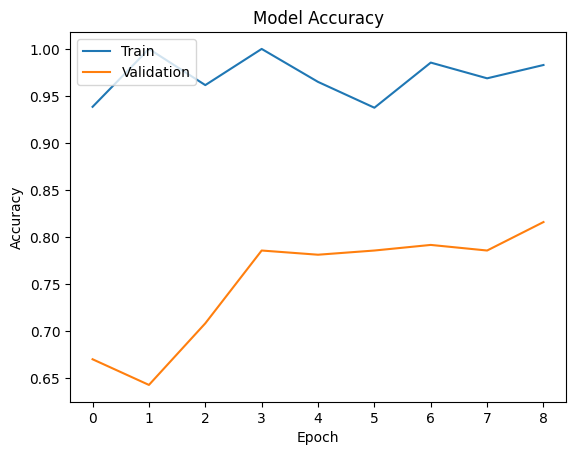

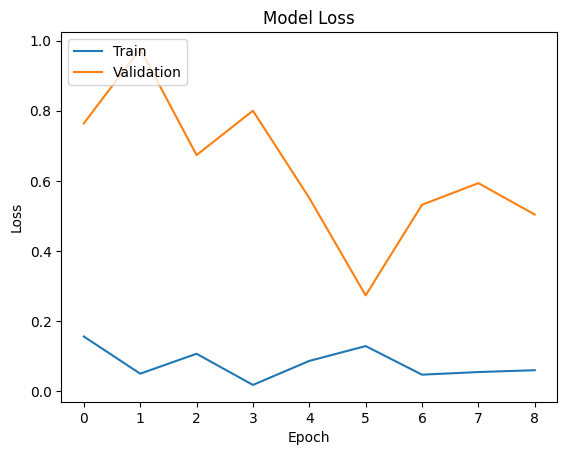

In [20]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: Left
Confidence score: 1.0000


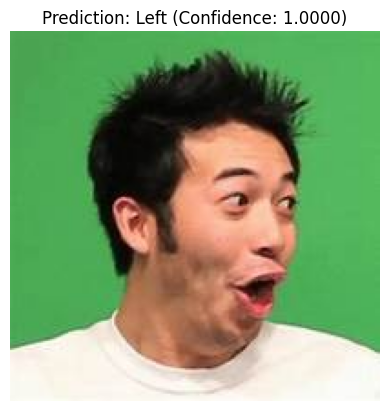

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: Left
Confidence score: 0.8338


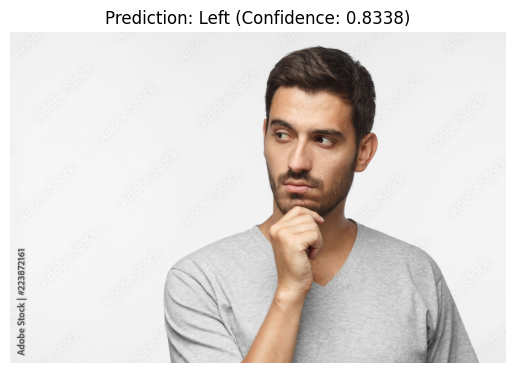

In [21]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/looking_left/pertama/model_looking_left.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # img_array /= 255.  # Normalize the image if your model expects normalized input
    return img_array

# Function to predict and display results
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)

    if prediction[0][0] > 0.5:
        label = "Left"
    else:
        label = "Front Facing"

    confidence = prediction[0][0] if label == "Left" else 1 - prediction[0][0]

    print(f"Prediction: {label}")
    print(f"Confidence score: {confidence:.4f}")
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path1 = "../datasets/test/test/left.jpeg"
test_image_path2 = "../datasets/test/test/1000_F_223872161_YZ98dGUBv8Oh7ce3WgF4JRbT9u07Nv4m.jpg"

predict_image(test_image_path1)
predict_image(test_image_path2)

In [22]:
import time

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '../model_download/looking_left/pertama/model_looking_left.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Mengukur latensi model TFLite
def measure_tflite_latency(image_path, tflite_model_path, num_runs=100):
    # Memuat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Mendapatkan ukuran input yang diharapkan
    input_shape = input_details[0]['shape'][1:3]
    
    preprocessed_image = preprocess_image(image_path, target_size=input_shape)
    
    # Warm-up
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average TFLite latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/left2.jpg"
measure_tflite_latency(test_image_path, tflite_model_path)

INFO:tensorflow:Assets written to: /tmp/tmpt3xpw13d/assets


INFO:tensorflow:Assets written to: /tmp/tmpt3xpw13d/assets


Saved artifact at '/tmp/tmpt3xpw13d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140123591728944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123586109232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123586116272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123591721200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123591723664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123591721552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123586108352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123586109584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123586113632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140123586102368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14011969465

W0000 00:00:1732260524.493901   12157 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732260524.494175   12157 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 14:28:44.496745: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt3xpw13d
2024-11-22 14:28:44.520926: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 14:28:44.520985: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpt3xpw13d
2024-11-22 14:28:44.751093: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 14:28:45.873799: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpt3xpw13d
2024-11-22 14:28:46.148917: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1652228 microseconds.


Average TFLite latency over 100 runs: 0.000939 seconds


In [ ]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/looking_left/pertama/model_looking_left.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/looking_left/model_looking_left_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmpn3ctr09s/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3ctr09s/assets


Saved artifact at '/tmp/tmpn3ctr09s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140120299351280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299427744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299429856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299423168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299425456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299435488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299426688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299437600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299436544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120299456112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012029946

W0000 00:00:1732260540.564848   12157 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732260540.564922   12157 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 14:29:00.565219: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn3ctr09s
2024-11-22 14:29:00.579598: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 14:29:00.579655: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpn3ctr09s
2024-11-22 14:29:00.756050: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 14:29:01.656429: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpn3ctr09s
2024-11-22 14:29:01.884579: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1319367 microseconds.


Model TFLite dengan kuantisasi rentang dinamis telah disimpan.


: 